In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime as dt

from stumpy.floss import _cac
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
from scipy.signal import find_peaks
from fnmatch import fnmatch, fnmatchcase
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
from math import sqrt
import os
import math

plt.rcParams['font.sans-serif']=['STSong']
plt.rcParams['figure.figsize'] = [5, 1]
plt.rcParams["figure.dpi"] = 400 # 设置分辨率

- 1D 插值
- 片段拼接， segs 1 ~ 10
- 左右拼接，即不同位置imu拼接，原始三轴数据与线性幅值加速度拼接
- 打标签

In [2]:
# 动作类型
activity_list = ['LegCurl', 'Lunge', 'Squat', 'SideKick', 'HighKick', 'HighKnees']

读取文件(测试)

In [4]:
root = r'D:\个人文档\data_collect\0526\csv\01-CT-H-3.csv'
dict_path = root.partition('\\csv\\')[0] + '\\segements_ste_slope\\'
file_type = root.partition('\\csv\\')[2].replace('.csv','')
df = pd.read_csv(root,header=0)

df.shape

(3552, 42)

获得所有文件的最大长度——即进一步插值长度

In [47]:
# 幅值加速度目录和原始数据目录单独运行
# seg_path = r'"D:\个人文档\data_collect\0702\final\02\test\segments_features\segments_amplitude_raw"'
# seg_path = r'D:\个人文档\data_collect\0702\final\02\segments_raw_data'
seg_path = r'D:\个人文档\data_preprocessing\0721\01\final\segments_amplitude_raw'

filepath_list = []

length = 0

for dirpath, dirnames, filenames in os.walk(seg_path):
    # print(filenames)
    for filepath in filenames:
        # print(filepath)
        if fnmatch(filepath, '*.csv'):
            filepath_list.append(os.path.join(dirpath, filepath))
            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
            if len(df) > length:
                length = len(df)

length, len(filepath_list)

(300, 1320)

In [48]:
# dictname = filepath_list[0].partition('segments_features\\')[2].partition('\\')[0]
dictname = seg_path
filepath_list[0], dictname

('D:\\个人文档\\data_preprocessing\\0721\\01\\final\\segments_amplitude_raw\\01-CT-L-30-1-raw_amplitude4-1.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\segments_amplitude_raw')

In [49]:
interpolated_dictname = dictname.replace('amplitude_raw', 'amplitude_raw_interpolated')
# interpolated_dictname = dictname.replace('segments_raw_data', 'segments_raw_data_interpolated')
interpolated_dictname

'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\segments_amplitude_raw_interpolated'

In [44]:
def mkdir(path):
    # 去除首位空格
    # path=path.strip()
    # 去除尾部 \ 符号
    # path=path.rstrip("\\")
    # 判断路径是否存在
    # 存在     True
    # 不存在   False
    isExists=os.path.exists(path)
    # 判断结果
    if not isExists:
        # 如果不存在则创建目录
        # 创建目录操作函数
        os.makedirs(path) 
        print(path+' 创建成功')
        return True
    else:
        # 如果目录存在则不创建，并提示目录已存在
        print(path+' 目录已存在')
        return False

##### 一维线性插值

In [50]:
# 1d interpolation
from scipy.interpolate import interp1d
# 多通道插值
def interpolate(df, length):
    X_interpolated = list()
    # 选取压力通道
    for label in df.columns:
        # 获取相应压力通道数据
        data = np.array(df[label])
        X = data

        # 插值到对应IMU数据长度
        len = length
        x = np.linspace(0, 1, X.shape[0])
        # 两种插值方式
        # f = interp1d(x, X, axis=0)
        f = interp1d(x, X, axis=0, kind='cubic')
        xnew = np.linspace(0, 1, length)
        ynew = f(xnew)
        X_interpolated.append(ynew)

    return np.array(X_interpolated).T

In [51]:
# 遍历，多文件插值
interpolated_path = interpolated_dictname

length = 468

mkdir(interpolated_path)

for root in filepath_list:
    # print(root)
    df = pd.read_csv(root,header=0)
    if len(df) < length:   
        df_interpolate = interpolate(df, length)
        df_interpolate = pd.DataFrame(df_interpolate.reshape(length, df.shape[1]), columns=df.columns)
        # df_interpolate.to_csv(root.replace('segments_raw_data', 'segments_raw_data_interpolated'), index=False)
        df_interpolate.to_csv(root.replace('amplitude_raw', 'amplitude_raw_interpolated'), index=False)
    else:
        # df.to_csv(root.replace('segments_raw_data', 'segments_raw_data_interpolated'), index=False)
        df.to_csv(root.replace('amplitude_raw', 'amplitude_raw_interpolated'), index=False)

# df_interpolate.shape

D:\个人文档\data_preprocessing\0721\01\final\segments_amplitude_raw_interpolated 创建成功


##### 连接 + 打标签
- 原始数据 X Y Z , 幅值加速度 Amplitude
- 首先将原始数据各个imu的数据拼接，再将拼接后的各列组合

- "D:\个人文档\data_collect\0702\final\02\test\segments_features\segments_amplitude_raw_interpolate\02-LegCurl-30-L-1-raw_amplitude4-1.csv"
- "D:\个人文档\data_collect\0702\final\02\test\segments_features\segments_raw_data_interpolated\02-LegCurl-30-L-1-raw_RawData4-1.csv"

In [54]:
# 去除左右分别采集文件的L，R标识，方便后续拼接操作
test_path = r'D:\个人文档\data_preprocessing\0721\01\final\segments_amplitude_raw_interpolated'
# filter_path = test_path.replace('segments_raw_data_interpolated', 'raw_data_interpolated_filter_LR')
filter_path = test_path.replace('segments_amplitude_raw_interpolated', 'raw_amplitude_interpolated_filter_LR')

mkdir(filter_path)
filepath_list = []

for dirpath, dirnames, filenames in os.walk(test_path):
    for filepath in filenames:
        if fnmatch(filepath, '*-L*.csv') or fnmatch(filepath, '*-R*.csv'):
            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
            df.to_csv(os.path.join(filter_path, filepath.replace('-L-','-').replace('-R-','-')), index=False)

D:\个人文档\data_preprocessing\0721\01\final\raw_amplitude_interpolated_filter_LR 创建成功


In [65]:
# 拼接幅值数据模块
path = r'D:\个人文档\data_preprocessing\0721\01\final\raw_amplitude_interpolated_filter_LR'
amplitude_concat_path = path.replace('filter_LR', 'filter_LR_concat')

mkdir(amplitude_concat_path)

for i in range(1, 4):
    for j in range(1, 11):
        filepath_list = []
        flag = False

        for dirpath, dirnames, filenames in os.walk(path):
            for filepath in filenames:
                # if fnmatch(filepath, '*01-Lun-H-1-raw_amplitude*-2.csv'):
                if fnmatch(filepath, '*01-CT-90-' + str(i) + '-raw_amplitude*-' + str(j) + '.csv'):
                # if fnmatch(filepath, '*01-Lunge-90-3-raw_amplitude*-' + str(i) + '.csv'):
                    filepath_list.append(os.path.join(dirpath, filepath))
                    df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
                    if flag:
                        # d_new = np.append(d_new,df.to_numpy())
                        d_new = pd.concat([d_new, df], axis=1, join='inner')
                    else:
                        d_new = df
                        file_type = filepath.partition('-raw_amplitude')[0] + '-segment' + filepath.partition('-raw_amplitude')[2].partition('-')[2].replace('.csv','')
                        flag = True

        print(d_new.shape)
        # print(file_type + '-' + str(i))

        # d_new = pd.DataFrame(d_new.reshape((d_new.shape[0]//4), 4, order='F'), columns=['amplitude2', 'amplitude3', 'amplitude4', 'amplitude5'])
        d_new.to_csv(amplitude_concat_path + '\\' + file_type + '.csv', index=False)

D:\个人文档\data_preprocessing\0721\01\final\raw_amplitude_interpolated_filter_LR_concat 目录已存在
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)
(468, 4)


In [76]:
# 拼接原始数据模块
path = r'D:\个人文档\data_preprocessing\0721\01\final\raw_data_interpolated_filter_LR'
data_concat_path = path.replace('filter_LR', 'filter_LR_concat')

mkdir(data_concat_path)

for i in range(1, 4):
    for j in range(1, 11):
        filepath_list = []
        flag = False

        for dirpath, dirnames, filenames in os.walk(path):
            for filepath in filenames:
                if fnmatch(filepath, '*01-GTT-90-' + str(i) + '-raw_RawData*-' + str(j) + '.csv'):
                # if fnmatch(filepath, '*01-Lunge-90-' + str(i) + '-raw_RawData*-' + str(j) + '.csv'):
                    filepath_list.append(os.path.join(dirpath, filepath))
                    df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
                    if flag:
                        d_new = pd.concat([d_new, df], axis=1, join='inner')
                    else:
                        d_new = df
                        file_type = filepath.partition('-raw_RawData')[0] + '-segment' + filepath.partition('-raw_RawData')[2].partition('-')[2].replace('.csv','')
                        flag = True

        print(d_new.shape)

        d_new.to_csv(data_concat_path + '\\' + file_type + '.csv', index=False)

D:\个人文档\data_preprocessing\0721\01\final\raw_data_interpolated_filter_LR_concat 目录已存在
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)
(468, 12)


重置列名

In [80]:
root = r'D:\个人文档\data_preprocessing\0721\01\final\raw_data_interpolated_filter_LR_concat'

filepath_list = []
flag = True

for dirpath, dirnames, filenames in os.walk(root):

    for filepath in filenames:

        df = pd.read_csv(os.path.join(dirpath, filepath),header=0)

        # df.columns = ['amplitude2', 'amplitude3', 'amplitude4', 'amplitude5']
        # df.columns = df.columns.str.replace("amplitude2", "02-A-amplitude")
        # df.columns = df.columns.str.replace("amplitude3", "03-A-amplitude")
        # df.columns = df.columns.str.replace("amplitude4", "05-A-amplitude")
        # df.columns = df.columns.str.replace("amplitude5", "06-A-amplitude")
        filetype = filepath.replace('CT', 'SideKick')
        filetype = filetype.replace('GTT', 'HighKick')
        filetype = filetype.replace('HK', 'HighKnees')

        df.to_csv(os.path.join(dirpath, filetype), index=False)


打标签
- 动作类型
- 完成度
- 分割片段次序
- IMU位置(通过列索引可知)

In [81]:
# 所有幅值拼接后的路径
# root_amplitude_concat = amplitude_concat_path
root_amplitude_concat = r'D:\个人文档\data_preprocessing\0721\01\final\raw_amplitude_interpolated_filter_LR_concat'
# 所有原始数据拼接后的路径
# root_rawdata_concat = data_concat_path
root_rawdata_concat = r'D:\个人文档\data_preprocessing\0721\01\final\raw_data_interpolated_filter_LR_concat'
# 连接幅值拼接后数据和原始数据拼接后数据以及打完标签后的路径
root_tag_concat = root_amplitude_concat.replace('raw_amplitude_interpolated_filter_LR_concat', 'tag_concat')

filepath_list = []
flag = False

mkdir(root_tag_concat)

# dirpath    D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_concat
# filepath   01-Squat-M-2-segment9.csv
# os.path.join(dirpath, filepath)      D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_concat\01-Squat-M-2-segment9.csv

for dirpath, dirnames, filenames in os.walk(root_amplitude_concat):

    for filepath in filenames:

        filepath_list.append(os.path.join(dirpath, filepath))

        df1 = pd.read_csv(os.path.join(dirpath, filepath).replace('raw_amplitude_interpolated_filter_LR_concat', 'raw_data_interpolated_filter_LR_concat'),header=0)
        df2 = pd.read_csv(os.path.join(dirpath, filepath),header=0)

        # 拼接
        df = pd.concat([df1, df2], axis=1, join='inner')

        # filepath "02-LegCurl-30-1-segment1"
        user_id = filepath.partition('-')[0].replace('0', '') # 用户ID
        activity = filepath.partition('-')[2].partition('-')[0] # 动作类型
        extent = filepath.partition('-')[2].partition('-')[2].partition('-')[0] # 完成度
        num_group = filepath.partition('-segment')[0][-1] # 组别序号
        num_seg = filepath.partition('segment')[2].replace('.csv','') # 分割序号

        df.insert(loc=df.shape[1], column='user_id', value=user_id)
        df.insert(loc=df.shape[1], column='activity', value=activity)
        df.insert(loc=df.shape[1], column='extent', value=extent)
        df.insert(loc=df.shape[1], column='num_group', value=num_group)
        df.insert(loc=df.shape[1], column='num_seg', value=num_seg)

        # print("df.shape:{0:>6}".format(str(df.shape)))

        # df.to_csv(root_tag + '\\' + filepath.replace('csv','txt') , index=False, sep='\t')
        df.to_csv(root_tag_concat + '\\' + filepath , index=False)

D:\个人文档\data_preprocessing\0721\01\final\tag_concat 创建成功


In [40]:
root = r'D:\个人文档\data_preprocessing\0721\01\final\01tag_concat_6'

filepath_list = []
shape_list = []
flag = True

for dirpath, dirnames, filenames in os.walk(root):

    for filepath in filenames:

        df = pd.read_csv(os.path.join(dirpath, filepath),header=0)

        if '02-A-amplitude' not in df.columns:
            filepath_list.append(os.path.join(dirpath, filepath))

filepath_list

['D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment1.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment10.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment2.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment3.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment4.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment5.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment6.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment7.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment8.csv',
 'D:\\个人文档\\data_preprocessing\\0721\\01\\final\\01tag_concat_6\\01-CT-50-2-segment9.csv']

In [82]:
# 0612 data
flag = False
filepath_list = list()
# root_tag = r'/kaggle/input/0612-amplitude-raw-tag/segments_amplitude_raw_tag'
root_tag = r'D:\个人文档\data_preprocessing\0721\01\final\tag_concat'
lenth = 0
count = 0

for dirpath, dirnames, filenames in os.walk(root_tag):
    # print(filenames)
    for filepath in filenames:
        if fnmatch(filepath, '*.csv'):
            count += 1
            filepath_list.append(os.path.join(dirpath, filepath))

            df = pd.read_csv(os.path.join(dirpath, filepath), header=0)

            if flag:
                d_new = pd.concat([d_new, df], axis=0, ignore_index=True, join="inner")
                # d_new = pd.concat([d_new, df], axis=0, ignore_index=True)
            else:
                d_new = df.copy()
                flag = True
                length = len(df)

df = d_new

df.shape, length, count

((322920, 21), 468, 690)

In [83]:
df.sample(5)

,02-A-x,02-A-y,02-A-z,03-A-x,03-A-y,03-A-z,05-A-x,05-A-y,05-A-z,06-A-x,...,06-A-z,02-A-amplitude,03-A-amplitude,05-A-amplitude,06-A-amplitude,user_id,activity,extent,num_group,num_seg
7314,-0.277502,1.027530,-0.107777,0.046673,0.954808,-0.122160,0.610624,0.804438,-0.066786,0.261073,...,-0.023472,0.089891,-0.016258,0.032153,0.133086,1,HighKick,30,2,5
27472,-0.313961,1.145007,-0.226392,-0.239373,1.329966,-0.172213,0.387060,0.956820,-0.214985,0.029729,...,-0.276499,0.228925,0.382631,0.074063,0.456421,1,HighKick,50,3,8
179956,-0.612066,0.837269,0.076896,0.209295,1.057520,0.185621,0.538420,0.890463,-0.220758,-0.252662,...,-0.093330,0.059995,0.113847,0.083789,-0.035479,1,Lunge,50,3,4
297419,-0.680529,0.657778,-0.142513,0.410188,0.874851,0.193317,0.624841,0.734288,-0.039536,-0.431120,...,-0.024307,-0.022847,0.005111,-0.015037,0.040136,1,Squat,70,1,5
120476,0.113305,0.965447,-0.129378,0.610736,0.788936,0.101144,-0.020244,0.986833,-0.189171,-0.588475,...,0.000215,0.000644,0.022244,0.024994,0.000477,1,LegCurl,50,2,7


##### 运动强度 - 短时能量最大值

In [34]:
ste_path = r'D:\个人文档\data_collect\0612\segments_ste_raw'

flag = False
count = 0
filepath_list = []
period_list = []

for dirpath, dirnames, filenames in os.walk(ste_path):
    # print(filenames)
    for filepath in filenames:
        if fnmatch(filepath, '01-Lun-H-1-raw_ste2*.csv'):
            count += 1
            filepath_list.append(os.path.join(dirpath, filepath))

            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
            period_list.append(len(df))

            if flag:
                d_new = np.append(d_new,df['03-A-ste'].to_numpy())
            else:
                d_new = df['03-A-ste'].to_numpy()
                flag = True
                print(df.shape)

count, d_new.shape, df.shape

(18, 1)


(10, (169,), (16, 1))

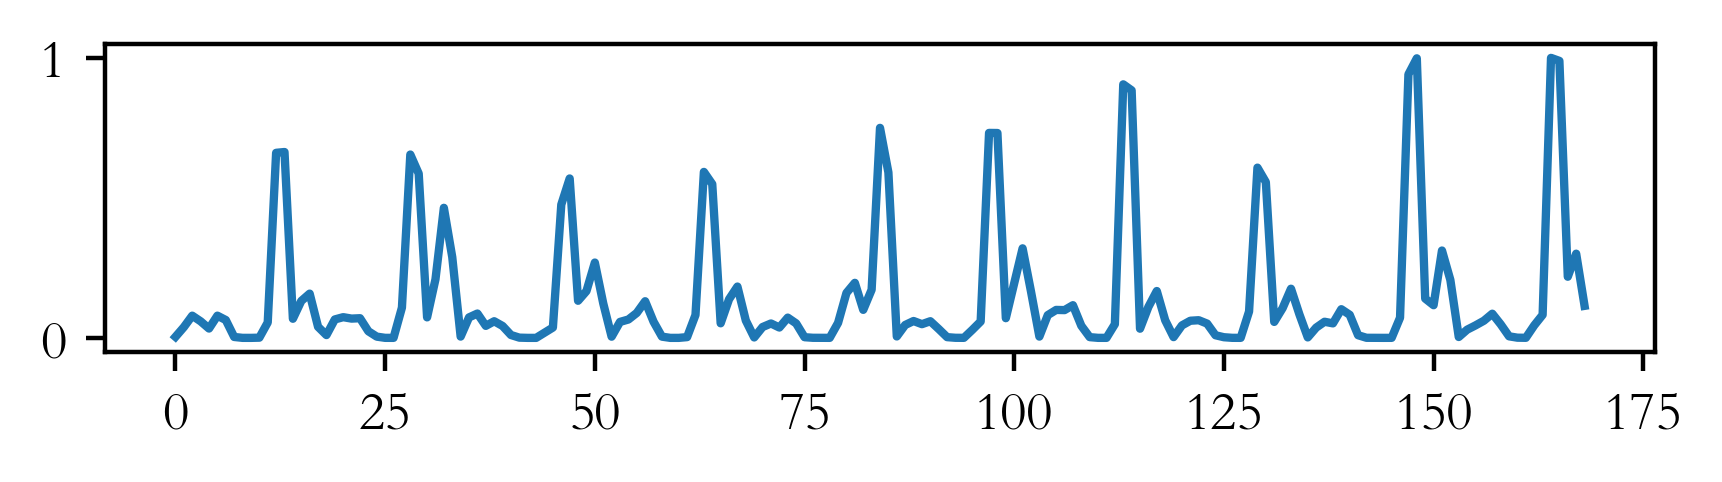

In [35]:
plt.rcParams['figure.figsize'] = [5, 1]
plt.plot(d_new)

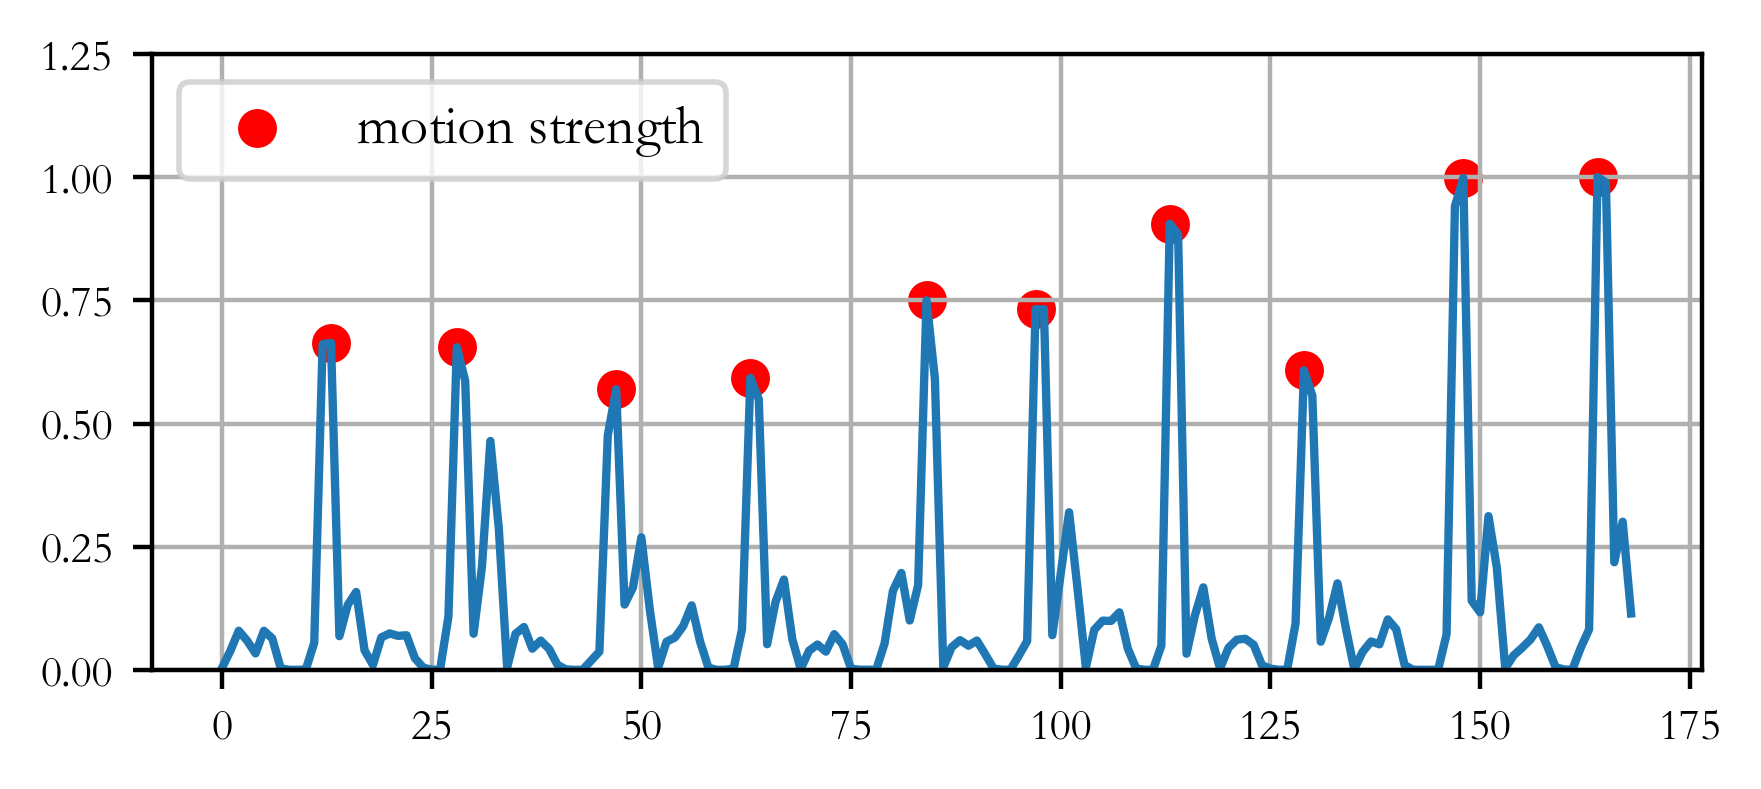

In [36]:
peak1, _ = find_peaks(d_new, height=0.3, distance=len(d_new)//20)

plt.rcParams['figure.figsize'] = [5, 2]
plt.ylim(0, 1.25)
plt.plot(d_new)
plt.scatter(peak1, d_new[peak1], color='red', label='motion strength')
plt.legend(loc='upper left')
plt.tick_params(labelsize=8)
plt.grid()

In [37]:
peak1

array([ 13,  28,  47,  63,  84,  97, 113, 129, 148, 164], dtype=int64)

In [38]:
benchmark = 0
for i in range(5):
    benchmark += d_new[peak1[i]]

benchmark /= 5
benchmark

0.6461841435794435

In [39]:
standard_deviation = 0
total = 0
for i in peak1:
    total += d_new[i]

ave = total / len(peak1)
ave

0.7474883642870557

In [40]:
for i in range(len(peak1)):
    standard_deviation += (d_new[peak1[i]] - ave)**2

standard_deviation /= len(peak1)
standard_deviation = math.sqrt(standard_deviation)
standard_deviation

0.15575717335224576

In [41]:
Z_score = list()
for i in peak1:
    Z_score.append((d_new[i] - benchmark) / standard_deviation)
Z_score

[0.11330557663831761,
 0.05557089263879376,
 -0.4928917375537117,
 -0.34293194385083975,
 0.6669472121274429,
 0.5512815394194222,
 1.664806936052567,
 -0.24494977411221186,
 2.2612593093868716,
 2.2715862698689313]

In [42]:
S_TEN = list()
for i in Z_score:
    S_TEN.append((i*2 + 5.5))

S_TEN

[5.726611153276635,
 5.611141785277588,
 4.514216524892577,
 4.81413611229832,
 6.833894424254886,
 6.602563078838845,
 8.829613872105135,
 5.0101004517755765,
 10.022518618773743,
 10.043172539737864]

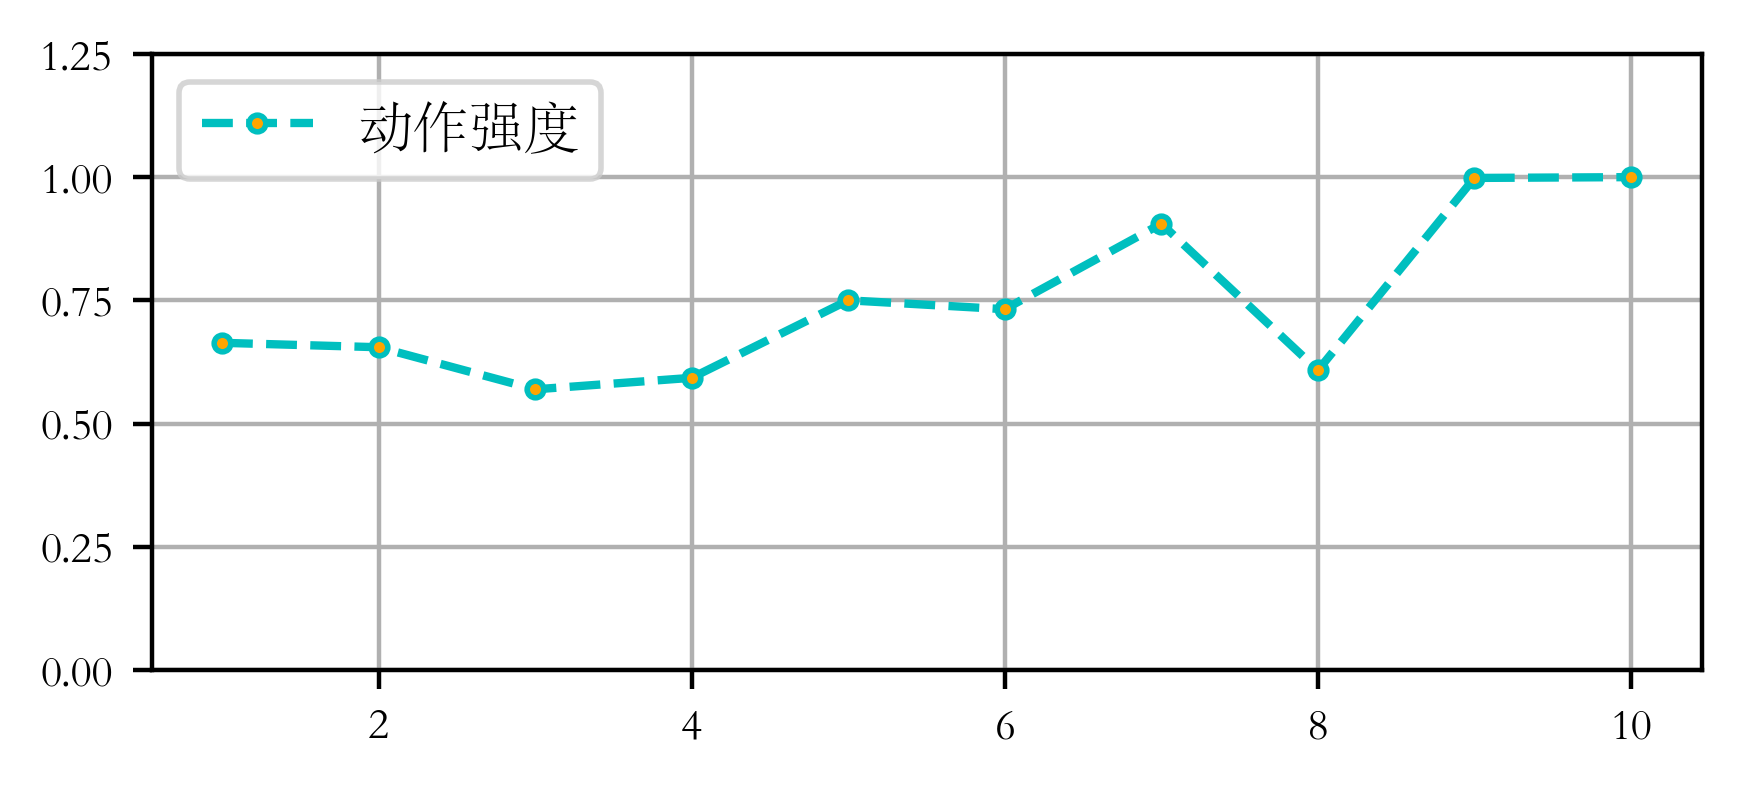

In [43]:
x_list = range(1, 11)

plt.ylim(0, 1.25)
plt.plot(x_list, d_new[peak1], label='动作强度', marker='.', mfc='orange', color='c', ls='--')
plt.legend(loc='upper left')
plt.tick_params(labelsize=8)
plt.grid()

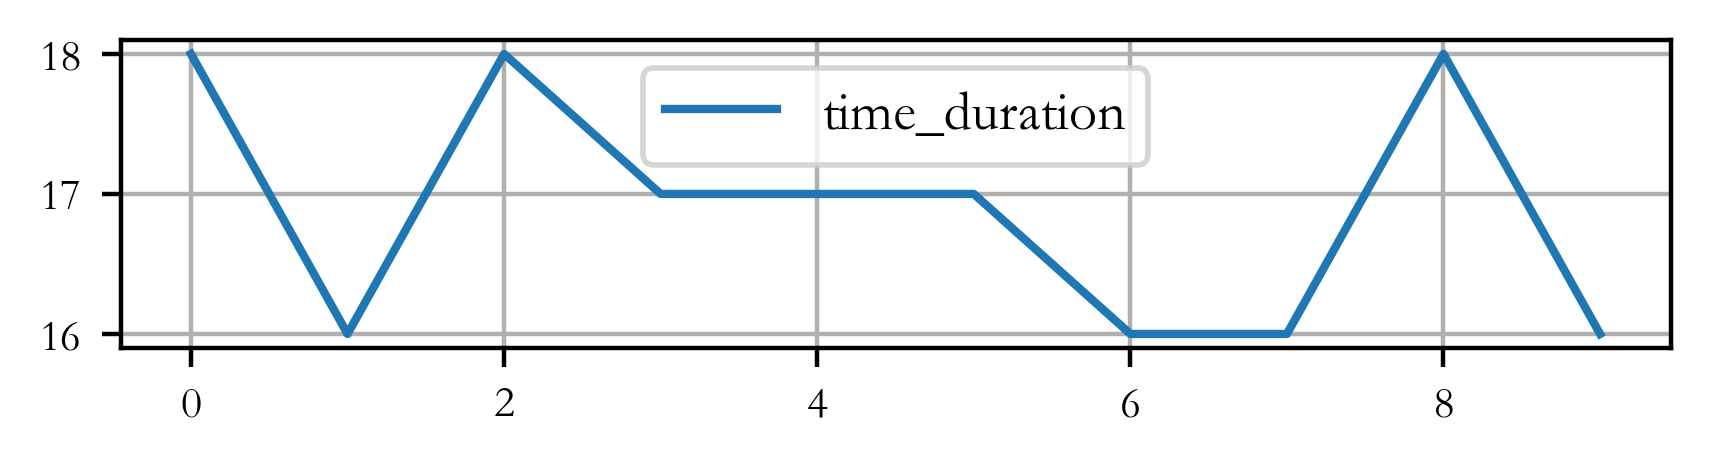

In [44]:
plt.rcParams['figure.figsize'] = [5, 1]
plt.grid()
plt.tick_params(labelsize=8)
plt.plot(period_list, label='time_duration')
plt.legend()

In [52]:
motion_strength = d_new[peak1]
time_period = period_list

baseline_MS = (motion_strength[0] + motion_strength[1]) / 2
baseline_TP = (period_list[0] + period_list[1]) / 2

baseline_MS, baseline_TP

(0.4629692891849496, 17.0)

In [57]:
len(motion_strength), len(time_period)

(10, 10)

In [63]:
# 原点坐标
origin_x = baseline_TP
origin_y = baseline_MS

motion_strength_list = []
time_period_list = []

for index, value in enumerate(time_period):
    # print(index, value)
    motion_strength_list.append((motion_strength[index]-origin_y)/origin_y)
    time_period_list.append((value-origin_x)/origin_x)

In [84]:
print(motion_strength_list)
print(time_period_list)

[0.04666353062294628, -0.0466635306229464, -0.2097533410342696, 0.006465016433160816, -0.07001696261930737, 1.1599704847820138, 0.9625688605813542, 0.33509943045927776, 1.089579029230296, 0.9016448719103883]
[0.0, 0.0, 0.11764705882352941, 0.0, 0.0, 0.0, -0.058823529411764705, -0.058823529411764705, 0.0, -0.058823529411764705]


Text(0, 0.5, 'MS deviation from the baseline')

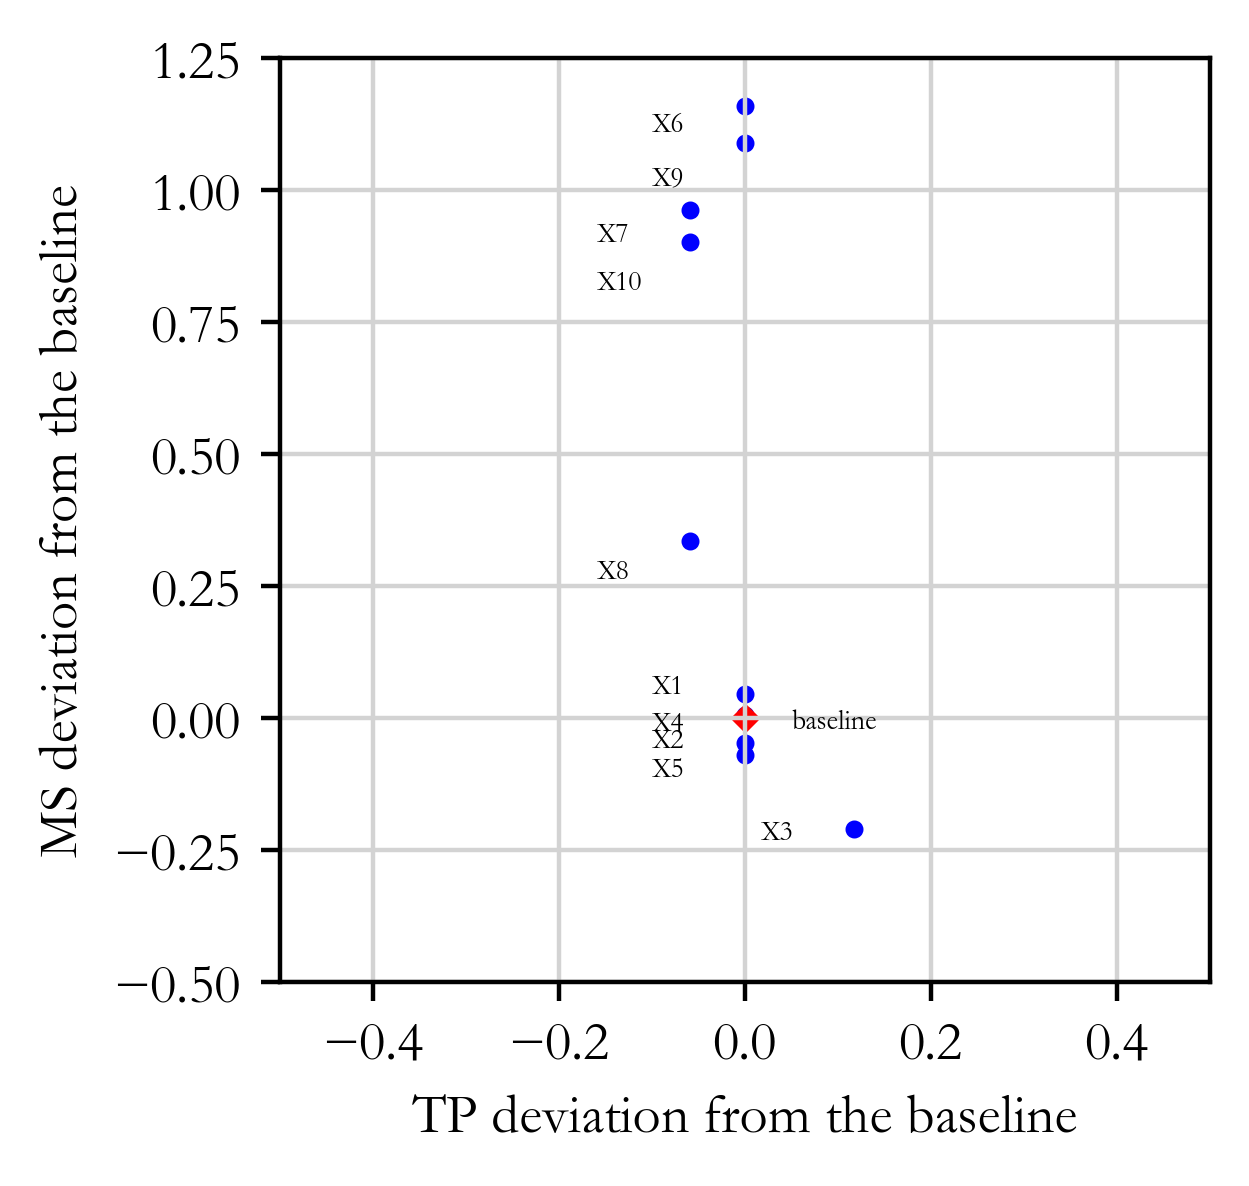

In [150]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.grid(c='lightgrey')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 1.25)
plt.scatter(time_period_list, motion_strength_list, marker='o', s=5, c='blue', label='score')
plt.scatter(0, 0, marker='D', s=8, c='red', label='baseline')
for i in range(len(time_period_list)):
    plt.annotate('X'+str(i+1), xy = (time_period_list[i], motion_strength_list[i]), 
    xytext = (time_period_list[i]-0.1, motion_strength_list[i]-0.01*i), size=5) # xy是需要标记的坐标，xytext是对应的标签坐标
plt.annotate('baseline', xy = (0, 0), 
xytext = (0+0.05, 0-0.02), size=5)
plt.xlabel('TP deviation from the baseline')
plt.ylabel('MS deviation from the baseline')
# plt.legend()

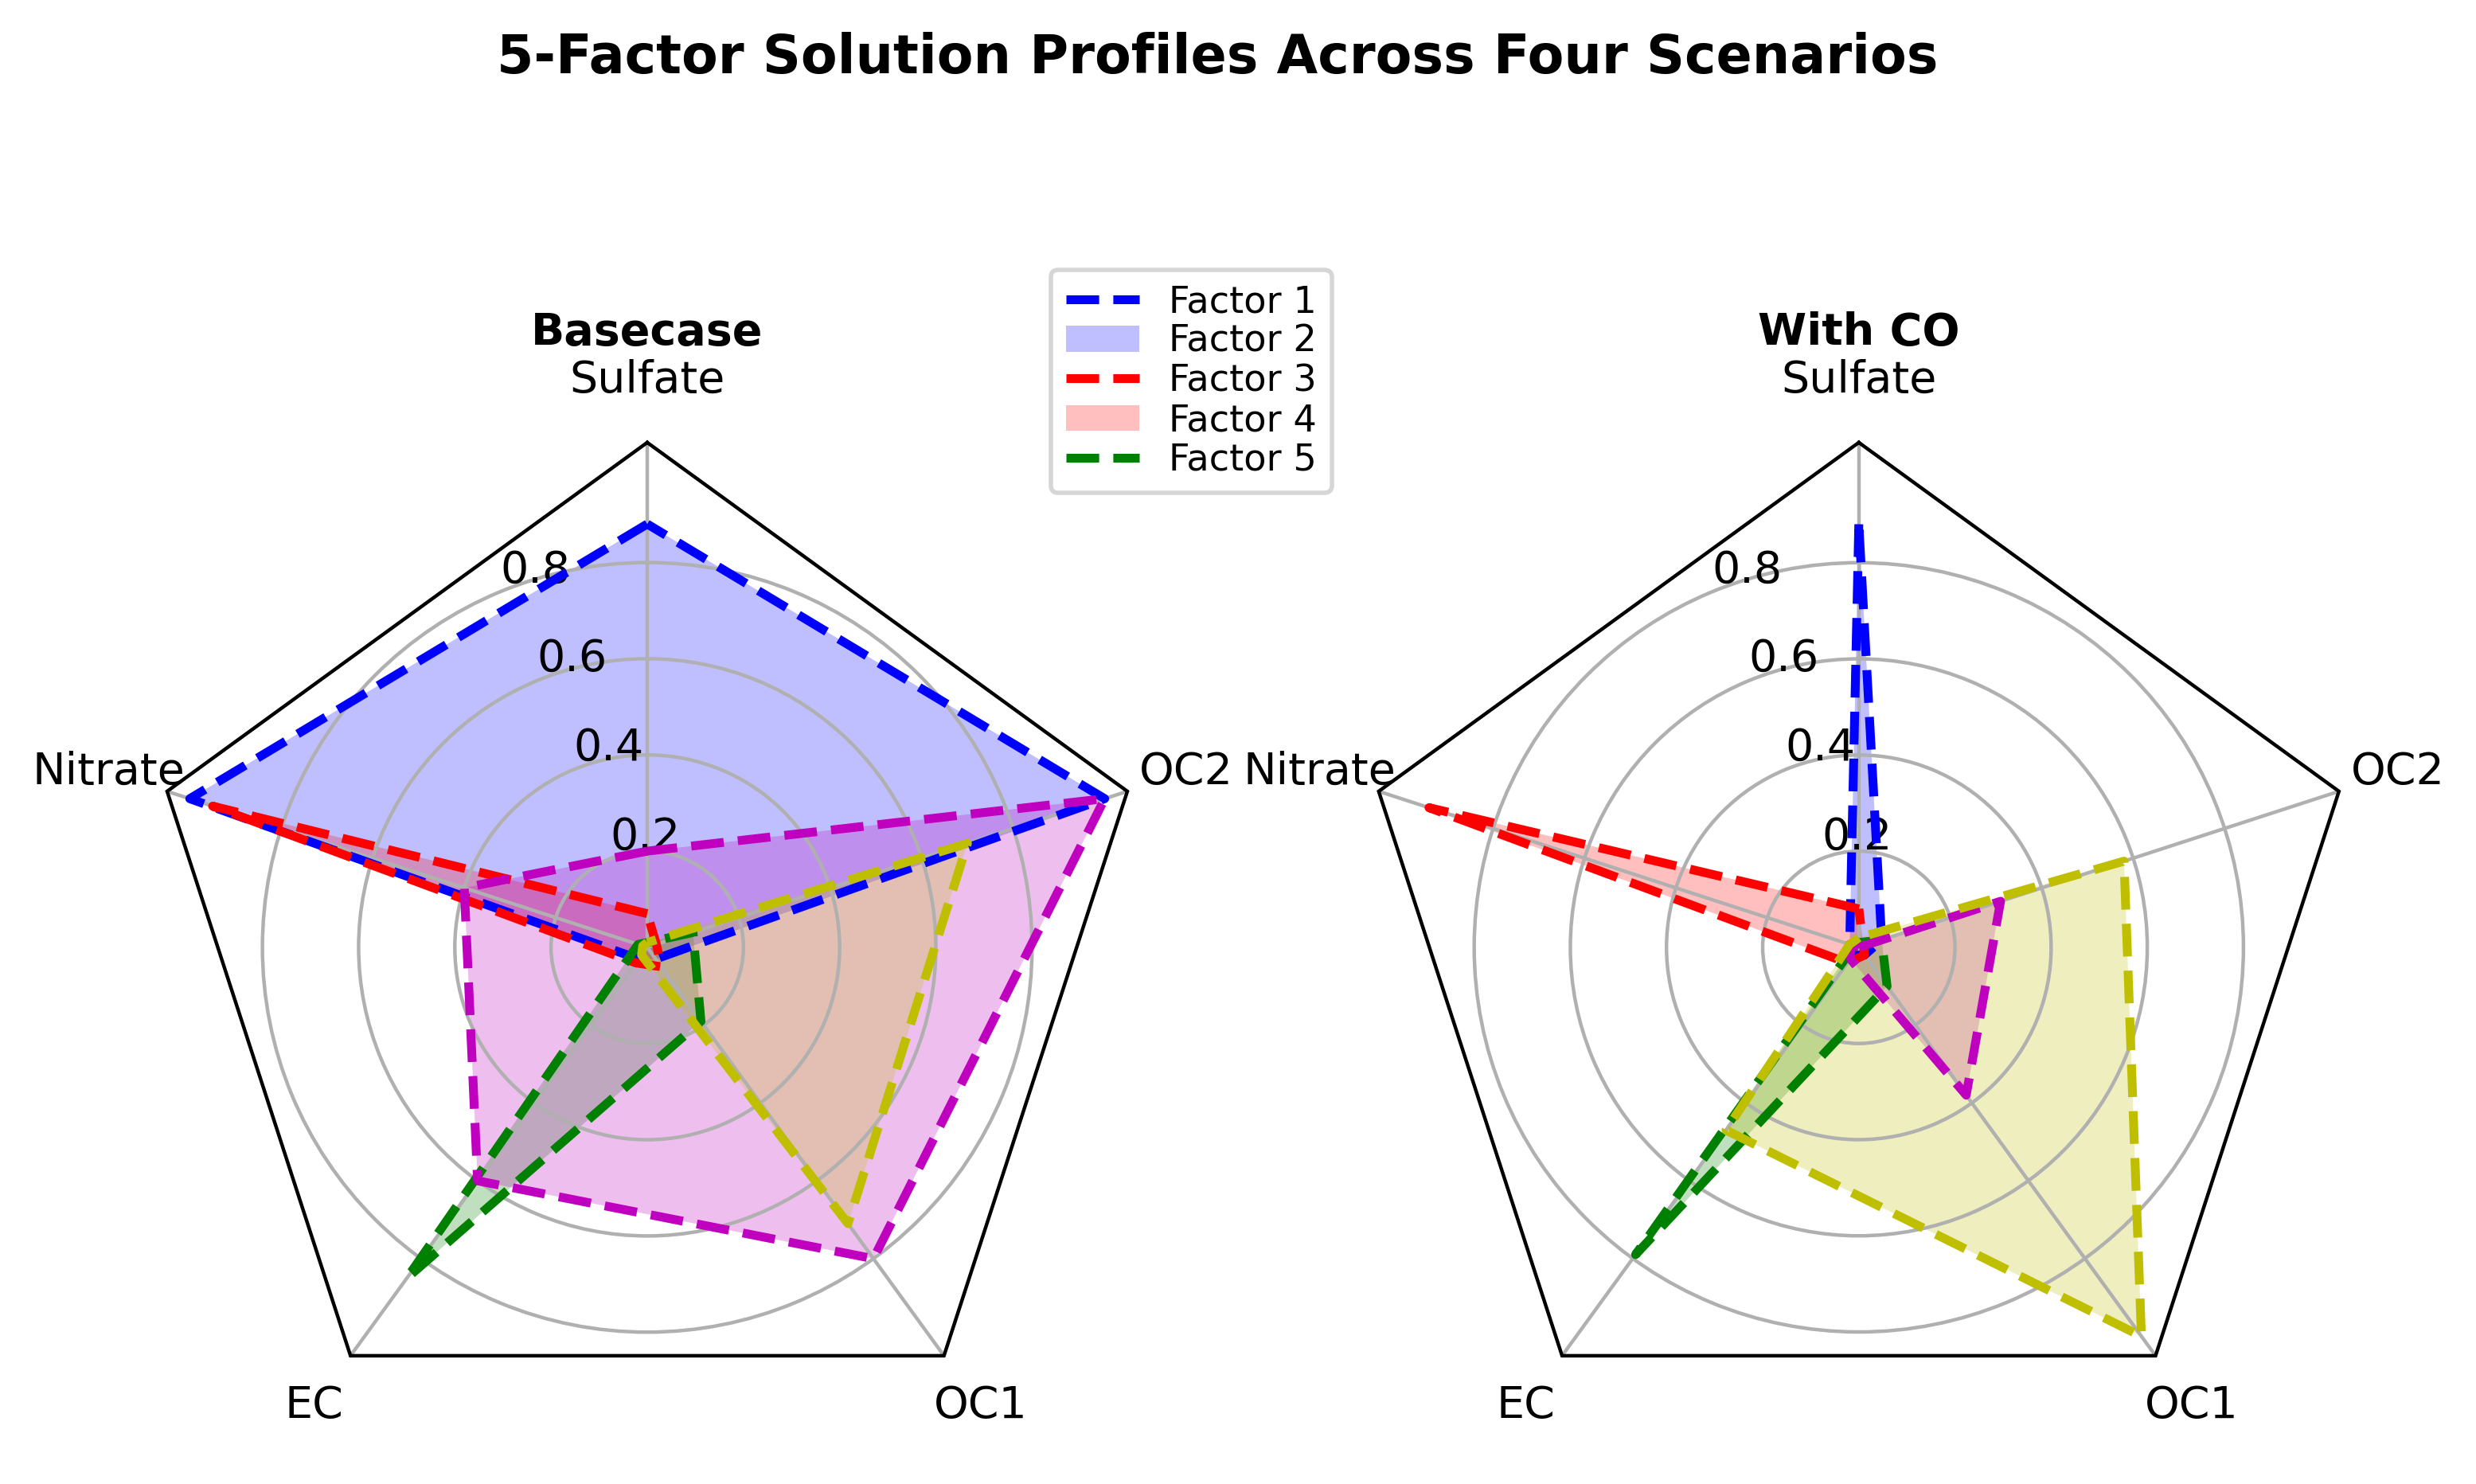

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
plt.rcParams["figure.dpi"] = 400 # 设置分辨率

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.
    This function creates a RadarAxes projection and registers it.
    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)#角度(弧度制)
    def draw_poly_patch(self):
        # rotate theta such that the first axis is at the top
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')
    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5) #画圆
        # return plt.patches.Polygon((0.5, 0.5), closed=True)
    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)
    class RadarAxes(PolarAxes):
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]
        def __init__(self, *args, **kwargs):
            super(RadarAxes, self).__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')
        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)
        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
        def _close_line(self, line):#使曲线封闭，首尾相连
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)
        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)
        def _gen_axes_patch(self):
            return self.draw_patch()
        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.
            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta

def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.
    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2'],
        ('Basecase', [
            [0.88, 1, 0.03, 0.03, 1],
            [0.07, 0.95, 0.04, 0.05, 0.02],
            [0.01, 0.02, 0.85, 0.19, 0.10],
            [0.2, 0.4, 0.6, 0.8, 1],
            [0.01, 0.01, 0.02, 0.71, 0.70]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.05],
            [0.08, 0.94, 0.04, 0.02, 0.01],
            [0.01, 0.01, 0.79, 0.10, 0.05],
            [0.00, 0.02, 0.03, 0.38, 0.31],
            [0.02, 0.02, 0.47, 1, 0.58]]),
        # ('With O3', [
        #     [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
        #     [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
        #     [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
        #     [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
        #     [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        # ('CO & O3', [
        #     [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
        #     [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
        #     [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
        #     [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
        #     [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data

if __name__ == '__main__':
    N = 5
    theta = radar_factory(N, frame='polygon')
    # theta = radar_factory(N, frame='circle')
    data = example_data()
    spoke_labels = data.pop(0)
    # fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
    #                          subplot_kw=dict(projection='radar'))
    fig, axes = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,
                             subplot_kw=dict(projection='radar'))
    # fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    colors = ['b', 'r', 'g', 'm', 'y']
    linestyles = ['--', ':']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color, linestyle="--", linewidth=2) ##本质是在极坐标下画封闭曲线
            ax.fill(theta, d, facecolor=color, alpha=0.25)##填充
        ax.set_varlabels(spoke_labels)
    # add legend relative to top-left plot
    ax = axes[0]
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')
    fig.text(0.5, 0.8, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    plt.show()